In [2]:
%run ../code/wavelets_pca_with_zhost_1100_average_precision.py

In [3]:
%run ../code/wavelets_pca_with_zhost_1100_roc_auc.py

In [4]:
%run ../processing/read_data.py

In [5]:
%run ../processing/functions.ipynb

In [7]:
import george as gg
import george.kernels as kr
import sncosmo as snc
import scipy.optimize as op
import pywt as wt

import os
import time
import numpy as np

from sklearn.decomposition import PCA

import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn import model_selection

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt



In [10]:
pd.set_option("display.max_rows", 6)

## Go direct to section Generating the labels, where we can pickle read the pickle files with the DFs processed

# ------------

## Loading GP and Wavelets function

In [87]:
def cleaning_df(df, method, clean_neg = True, percentage = 0.7):
    if clean_neg: #verifies if the value is negative and if it is under the error margin, if it is, turn to zero
        df[(df[:, 1] < 0) & (df[:, 1] > -df[:, 2]) , 1] = 0
        df = df[(df[:, 1] > 0)] #otherwise just cut off
    if method == 'std_dev': #cuts the points with error over the mean error + 1 std
        threshold = df.mean(axis = 0)[2] + df.std(axis = 0)[2]
        df_filter = df[(threshold>df[:,2])]
    elif method == 'percentage':
        threshold = df.max(axis = 0)[1] * percentage
        df_filter = df[(threshold>df[:,2])]
    elif method == '':
        df_filter = df
    return df_filter

def gaussian_process(data, filters, method, path, printar = True):
    path_to_export = path # '../../data/test/'
    x = np.linspace(data.MJD.min(), data.MJD.max(), 100)
    data_dict = {band: df[['MJD', 'FLUXCAL', 'FLUXCALERR']].values for band, df in data.groupby('FLT')}
    
    
    mus = {filters[0] : [], filters[1] : [], filters[2] : [], filters[3] : []}
    stds = {filters[0] : [], filters[1] : [], filters[2] : [], filters[3] : []}

    for band, df in data_dict.items():
        dat = cleaning_df(df, method)
        gp = gg.GP((500**2)*kr.ExpSquaredKernel(metric=20**2), fit_mean=True)
        gp.compute(dat[:,0], dat[:,2])  
        # Define the objective function (negative log-likelihood in this case).
        def nll(p):
            gp.set_parameter_vector(p)
            ll = gp.log_likelihood(dat[:,1], quiet=True)
            return -ll if np.isfinite(ll) else 1e25
    
        # And the gradient of the objective function.
        def grad_nll(p):
            gp.set_parameter_vector(p)
            return -gp.grad_log_likelihood(dat[:,1], quiet=True)
          
        p0 = gp.get_parameter_vector()
        results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
        
        mu, var = gp.predict(dat[:,1], x, return_var=True)
        std = np.sqrt(var)
        stds[band] = std
        mus[band] = mu 
        
        if printar:
            matplotlib.use('Agg')
            plt.ioff()
            fig = plt.figure(num=None, figsize=(8, 5), dpi = 8, facecolor='w', edgecolor='w')
            plt.plot(x, mu, color= 'k', linewidth = 5)
            plt.axis('off')
            plt.savefig(path_to_export + f[24:32] + '_'+ read_sn(f)['SIM_COMMENT'][3] +'_'+ band + '.png')
            plt.close(fig)
    
    return 0, x, mus, stds

#the keys are the names of the filters in order to be the dict keys
def get_wavelets(sn, keys, method,path, wavelet = 'sym2', mlev = 2 , printar = True):
    wav = wt.Wavelet(wavelet)
    
    fmin, xstar, mu, stds = gaussian_process_mat(sn, keys, method, path, printar = printar) 
    coeffs = [np.array(wt.swt(mu[filt], wav, level=mlev)).flatten() for filt in keys]

    return np.concatenate(coeffs)

In [88]:
def gaussian_process_mat(data, filters, method, path, printar = False):
    path_to_export = path # '../../data/test/'
    x = np.linspace(data.MJD.min(), data.MJD.max(), 100)
    data_dict = {band: df[['MJD', 'FLUXCAL', 'FLUXCALERR']].values for band, df in data.groupby('FLT')}
    
    
    mus = {filters[0] : [], filters[1] : [], filters[2] : [], filters[3] : []}
    stds = {filters[0] : [], filters[1] : [], filters[2] : [], filters[3] : []}

    for band, df in data_dict.items():
        dat = cleaning_df(df, method)
        gp = gg.GP((500**2)*kr.Matern52Kernel(metric=1), fit_mean=True)
        gp.compute(dat[:,0], dat[:,2])  
        # Define the objective function (negative log-likelihood in this case).
        def nll(p):
            gp.set_parameter_vector(p)
            ll = gp.log_likelihood(dat[:,1], quiet=True)
            return -ll if np.isfinite(ll) else 1e25
    
        # And the gradient of the objective function.
        def grad_nll(p):
            gp.set_parameter_vector(p)
            return -gp.grad_log_likelihood(dat[:,1], quiet=True)
          
        p0 = gp.get_parameter_vector()
        results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
        
        mu, var = gp.predict(dat[:,1], x, return_var=True)
        std = np.sqrt(var)
        stds[band] = std
        mus[band] = mu 

    
    return 0, x, mus, stds

In [89]:
path_to_read = '../../data/raw_data/'
files = []
for r, d, f in os.walk(path_to_read):
    for file in f:
        if '.DAT' in file:
            files.append(os.path.join(r, file))

### OBS: SOME FILES FOR SOME REASON COULD NOT BE PROCESSED USING WAVELETS, Those were:
### DES_SN076747, DES_SN076747. DES_SN813144
### ---------------------------
### Generating the files with treatment below

In [94]:
keys = ['desg' , 'desi' , 'desr' , 'desz']


In [95]:
#results_n = []


In [96]:
#%%time
#for i, f in enumerate(files):
#    results_n.append(get_wavelets(read_sn(path_to_read + f)['df'], keys, '', path = ''))
#
##Time running:  2.58798155758116

CPU times: user 1h 29min 38s, sys: 8.21 s, total: 1h 29min 46s
Wall time: 1h 37min 59s


In [97]:
len(results_n)

21316

In [76]:
find_object('013742', files)

[4044]

In [77]:
sn  = read_sn(path_to_read + files[4044])['df']

In [85]:
gaussian_process_mat(sn,keys, '', path = '', printar = True)

(0, array([  0.        ,   1.34122222,   2.68244444,   4.02366667,
          5.36488889,   6.70611111,   8.04733333,   9.38855556,
         10.72977778,  12.071     ,  13.41222222,  14.75344444,
         16.09466667,  17.43588889,  18.77711111,  20.11833333,
         21.45955556,  22.80077778,  24.142     ,  25.48322222,
         26.82444444,  28.16566667,  29.50688889,  30.84811111,
         32.18933333,  33.53055556,  34.87177778,  36.213     ,
         37.55422222,  38.89544444,  40.23666667,  41.57788889,
         42.91911111,  44.26033333,  45.60155556,  46.94277778,
         48.284     ,  49.62522222,  50.96644444,  52.30766667,
         53.64888889,  54.99011111,  56.33133333,  57.67255556,
         59.01377778,  60.355     ,  61.69622222,  63.03744444,
         64.37866667,  65.71988889,  67.06111111,  68.40233333,
         69.74355556,  71.08477778,  72.426     ,  73.76722222,
         75.10844444,  76.44966667,  77.79088889,  79.13211111,
         80.47333333,  81.81455556,  

In [79]:
sn

,MJD,FLT,FLUXCAL,FLUXCALERR,SNR,MAG,MAGERR,SIM_MAG
3,0.000,desz,4.492,3.427,1.31,99.000,5.000,99.070
4,5.863,desg,7.566,6.269,1.21,99.000,5.000,98.959
5,5.878,desr,5.901,5.079,1.16,99.000,5.000,99.047
...,...,...,...,...,...,...,...,...
96,132.769,desr,12.390,2.507,4.94,24.768,0.246,24.536
97,132.777,desi,20.600,4.890,4.21,24.215,0.294,24.291
98,132.781,desz,27.040,6.584,4.11,23.920,0.303,23.999


In [238]:
#keys = ['desg' , 'desi' , 'desr' , 'desz']
#
#start = time.time()
#
#results_stddev = []
#
#for i, f in enumerate(files):
#    
#    try:
#        #results_stddev.append(get_wavelets(read_sn(path_to_read + f)['df'], keys,'std_dev'))
#    except:
#        print("The file with problem was: " + str(f) + " index: " + str(i))
#
#end = time.time()
#print("Time running: " , (end - start)/3600) 
###Time running:  1.378045023083687

The file with problem was: ../../data/raw_data/DES_SN170148.DAT
The file with problem was: ../../data/raw_data/DES_SN844311.DAT
The file with problem was: ../../data/raw_data/DES_SN585441.DAT
The file with problem was: ../../data/raw_data/DES_SN089947.DAT
The file with problem was: ../../data/raw_data/DES_SN122840.DAT
The file with problem was: ../../data/raw_data/DES_SN671692.DAT
The file with problem was: ../../data/raw_data/DES_SN288256.DAT
The file with problem was: ../../data/raw_data/DES_SN769696.DAT
The file with problem was: ../../data/raw_data/DES_SN464421.DAT
The file with problem was: ../../data/raw_data/DES_SN183066.DAT
The file with problem was: ../../data/raw_data/DES_SN870945.DAT
The file with problem was: ../../data/raw_data/DES_SN148636.DAT
The file with problem was: ../../data/raw_data/DES_SN103896.DAT
The file with problem was: ../../data/raw_data/DES_SN030273.DAT
The file with problem was: ../../data/raw_data/DES_SN009140.DAT
The file with problem was: ../../data/ra

In [275]:
#keys = ['desg' , 'desi' , 'desr' , 'desz']
#
#start = time.time()
#
#results_perc = []
#
#for i, f in enumerate(files):
#    
#    #file_name = f[20:] #edit here everytime we change the folder
#    #read = read_sn(path_to_read + file_name)
#    #df = read['df']
#    
#    try:
#        #results_n.append(get_wavelets(read_sn(path_to_read + f)['df'], keys, ''))
#        #results_stddev.append(get_wavelets(read_sn(path_to_read + f)['df'], keys,'std_dev'))
#        results_perc.append(get_wavelets(read_sn(path_to_read + f)['df'], keys, 'percentage', '../../data/dl_marcelo_perc/'))
#    except:
#        print("The file with problem was: " + str(f) + " index: " + str(i))
#
#end = time.time()
#print("Time running: " , (end - start)/3600) 
###Time running:  2.58798155758116

The file with problem was: ../../data/raw_data/DES_SN210261.DAT index: 227
The file with problem was: ../../data/raw_data/DES_SN170148.DAT index: 582
The file with problem was: ../../data/raw_data/DES_SN367622.DAT index: 750
The file with problem was: ../../data/raw_data/DES_SN415102.DAT index: 825
The file with problem was: ../../data/raw_data/DES_SN792792.DAT index: 1100
The file with problem was: ../../data/raw_data/DES_SN398701.DAT index: 1575
The file with problem was: ../../data/raw_data/DES_SN844311.DAT index: 1625
The file with problem was: ../../data/raw_data/DES_SN486038.DAT index: 1654
The file with problem was: ../../data/raw_data/DES_SN585441.DAT index: 1711
The file with problem was: ../../data/raw_data/DES_SN128031.DAT index: 2100
The file with problem was: ../../data/raw_data/DES_SN282046.DAT index: 2158
The file with problem was: ../../data/raw_data/DES_SN367735.DAT index: 2485
The file with problem was: ../../data/raw_data/DES_SN089947.DAT index: 2555
The file with pr

/home/felipematheus/anaconda3/lib/python3.7/site-packages/george/gp.py:410: RuntimeWarning: invalid value encountered in subtract
  A = np.einsum("i,j", alpha, alpha) - K_inv


The file with problem was: ../../data/raw_data/DES_SN169212.DAT index: 20379
The file with problem was: ../../data/raw_data/DES_SN588165.DAT index: 20508
The file with problem was: ../../data/raw_data/DES_SN498066.DAT index: 21006
The file with problem was: ../../data/raw_data/DES_SN559445.DAT index: 21052
The file with problem was: ../../data/raw_data/DES_SN492802.DAT index: 21170
The file with problem was: ../../data/raw_data/DES_SN118863.DAT index: 21265
Time running:  3.5195248397191365


In [276]:
#keys = ['desg' , 'desi' , 'desr' , 'desz']
#
#start = time.time()
#
#for i, f in enumerate(files):
#    
#    #file_name = f[20:] #edit here everytime we change the folder
#    #read = read_sn(path_to_read + file_name)
#    #df = read['df']
#    
#    try:
#        #results_n.append(get_wavelets(read_sn(path_to_read + f)['df'], keys, ''))
#        #results_stddev.append(get_wavelets(read_sn(path_to_read + f)['df'], keys,'std_dev'))
#        gaussian_process(read_sn(path_to_read + f)['df'], keys, '', '../../data/dl_marcelo_no_treat/')
#    except:
#        print("The file with problem was: " + str(f) + " index: " + str(i))
#
#end = time.time()
#print("Time running: " , (end - start)/3600) 
###Time running:  2.58798155758116

Time running:  3.4882003411981795


In [277]:
#keys = ['desg' , 'desi' , 'desr' , 'desz']
#
#start = time.time()
#
#for i, f in enumerate(files):
#    
#    #file_name = f[20:] #edit here everytime we change the folder
#    #read = read_sn(path_to_read + file_name)
#    #df = read['df']
#    
#    try:
#        #results_n.append(get_wavelets(read_sn(path_to_read + f)['df'], keys, ''))
#        #results_stddev.append(get_wavelets(read_sn(path_to_read + f)['df'], keys,'std_dev'))
#        gaussian_process(read_sn(path_to_read + f)['df'], keys, 'std_dev', '../../data/dl_marcelo_stddev/')
#    except:
#        print("The file with problem was: " + str(f) + " index: " + str(i))
#
#end = time.time()
#print("Time running: " , (end - start)/3600) 
###Time running:  2.58798155758116

The file with problem was: ../../data/raw_data/DES_SN170148.DAT index: 582
The file with problem was: ../../data/raw_data/DES_SN844311.DAT index: 1625
The file with problem was: ../../data/raw_data/DES_SN585441.DAT index: 1711
The file with problem was: ../../data/raw_data/DES_SN089947.DAT index: 2555
The file with problem was: ../../data/raw_data/DES_SN122840.DAT index: 3050
The file with problem was: ../../data/raw_data/DES_SN671692.DAT index: 4676
The file with problem was: ../../data/raw_data/DES_SN288256.DAT index: 4987
The file with problem was: ../../data/raw_data/DES_SN769696.DAT index: 6064
The file with problem was: ../../data/raw_data/DES_SN464421.DAT index: 7506
The file with problem was: ../../data/raw_data/DES_SN183066.DAT index: 8897
The file with problem was: ../../data/raw_data/DES_SN870945.DAT index: 9822
The file with problem was: ../../data/raw_data/DES_SN148636.DAT index: 10965
The file with problem was: ../../data/raw_data/DES_SN103896.DAT index: 11145
The file wi

In [289]:
#print("Number of files with std_dev: ", len(results_stddev),". Number of files without treatment: ", len(results_n), "Number of files with percentage: ", len(results_perc))

Number of files with std_dev:  21290 . Number of files without treatment:  21316 Number of files with percentage:  21232


In [285]:
#pickle_out = open("../../models/wavelet_df_pipeline_Marcelo_SemTratamento.pickle","wb")
#pickle.dump(results_n, pickle_out)
#pickle_out.close()

In [286]:
#pickle_out = open("../../models/wavelet_df_pipeline_Marcelo_TratamentoStddev.pickle","wb")
#pickle.dump(results_stddev, pickle_out)
#pickle_out.close()

In [287]:
#pickle_out = open("../../models/wavelet_df_pipeline_Marcelo_TratamentoPerc.pickle","wb")
#pickle.dump(results_perc, pickle_out)
#pickle_out.close()

## Generating the labels:

In [7]:
not_in_stddev = [582,1625,1711,2555,3050,4676,4987,6064,7506,8897,9822,10965,11145,12290,12411,13205,13445,14301,14333,14608,14846,15059,16000,16178,17687,19156]
not_in_perc = [227,582,750,825,1100,1575,1625,1654,1711,2100,2158,2485,2555,2701,3644,3740,4079,4959,5205,5684,5904,5919,5961,6007,6424,6449,6641,6647,6749,6944,7313,8123,8849,8851,9012,9053,9475,9822,9823,9878,9986,10626,10831,11068,11219,11483,11493,11587,12723,13131,13445,13485,13664,13906,14169,14301,14315,14333,14846,15421,16352,16995,16999,17252,17371,17590,17650,17687,17959,17982,17999,18468,18537,18890,19100,19219,19297,20002,20379,20508,21006,21052,21170,21265]

In [297]:
#files_stddev = []
#files_perc = []
#for i, f in enumerate(files):
#    if i not in not_in_stddev:
#        files_stddev.append(f)
#    if i not in not_in_perc:
#        files_perc.append(f)

In [305]:
#(len(files_stddev) == len(results_stddev) and len(files_perc) == len(results_perc))

True

In [98]:
## Non optimize way of doing this
#
#labels_notreat = []
#labels_stddev = []
#labels_perc = []
#for f in files:
#    read = read_sn(f)
#    label = read['SIM_COMMENT'][3]
#    labels_notreat.append(label)
#    
#for f in files_stddev:
#    read = read_sn(f)
#    label = read['SIM_COMMENT'][3]
#    labels_stddev.append(label)
#    
#for f in files_perc:
#    read = read_sn(f)
#    label = read['SIM_COMMENT'][3]
#    labels_perc.append(label)

In [324]:
#(len(files_stddev) == len(labels_stddev) and len(files_perc) == len(labels_perc)) and len(files) == len(labels_notreat)

True

In [9]:
#pickle_out = open("../../models/label_SemTratamento.pickle","wb")
#pickle.dump(labels_notreat, pickle_out)
#p#ickle_out.close()

In [320]:
#pickle_out = open("../../models/labels_Stddev.pickle","wb")
#pickle.dump(labels_stddev, pickle_out)
#pickle_out.close()

In [321]:
#pickle_out = open("../../models/labels_Perc.pickle","wb")
#pickle.dump(labels_perc, pickle_out)
#pickle_out.close()

In [8]:
#pickle_results = open("../../models/wavelet_df_pipeline_Marcelo_SemTratamento.pickle","rb")
#pickle_labels = open("../../models/label_SemTratamento.pickle","rb")
#
#r1 = pickle.load(pickle_results)
#l1 = pickle.load(pickle_labels)

In [336]:
#l1==labels_notreat

True

In [335]:
#all(r1[0]==results_n[0])

True

In [9]:
#pickle_results = open("../../models/wavelet_df_pipeline_Marcelo_TratamentoStddev.pickle","rb")
#pickle_labels = open("../../models/labels_Stddev.pickle","rb")
#
#r2 = pickle.load(pickle_results)
#l2 = pickle.load(pickle_labels)

In [341]:
#l2==labels_stddev

True

In [342]:
#all(r2[-1]==results_stddev[-1])

True

In [10]:
#pickle_results = open("../../models/wavelet_df_pipeline_Marcelo_TratamentoPerc.pickle","rb")
#pickle_labels = open("../../models/labels_Perc.pickle","rb")
#
#r3 = pickle.load(pickle_results)
#l3 = pickle.load(pickle_labels)

In [345]:
#l3==labels_perc

True

In [346]:
#all(r3[-1]==results_perc[-1])

True

In [100]:
labels_notreat

['II',
 'II',
 'II',
 'II',
 'II',
 'Ia',
 'II',
 'Ibc',
 'II',
 'Ia',
 'Ia',
 'II',
 'II',
 'Ib',
 'Ia',
 'IIL',
 'II',
 'Ic',
 'Ia',
 'II',
 'II',
 'II',
 'II',
 'Ia',
 'II',
 'II',
 'II',
 'IIn',
 'II',
 'Ic',
 'Ib',
 'Ia',
 'Ib',
 'II',
 'Ib',
 'II',
 'IIn',
 'Ia',
 'II',
 'II',
 'Ib',
 'IIP',
 'Ic',
 'Ia',
 'Ia',
 'II',
 'II',
 'Ia',
 'Ia',
 'Ia',
 'IIL',
 'II',
 'II',
 'IIP',
 'Ia',
 'II',
 'II',
 'II',
 'Ia',
 'Ia',
 'II',
 'II',
 'II',
 'II',
 'Ia',
 'Ia',
 'IIn',
 'II',
 'IIn',
 'II',
 'Ib',
 'Ic',
 'II',
 'II',
 'Ia',
 'II',
 'Ia',
 'Ia',
 'II',
 'Ia',
 'II',
 'Ia',
 'II',
 'Ib',
 'II',
 'Ia',
 'Ia',
 'Ia',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'Ia',
 'II',
 'Ib',
 'II',
 'Ic',
 'Ia',
 'Ia',
 'II',
 'Ia',
 'Ia',
 'IIn',
 'Ib',
 'II',
 'II',
 'Ib',
 'II',
 'Ia',
 'Ia',
 'II',
 'Ia',
 'II',
 'Ib',
 'II',
 'II',
 'Ia',
 'II',
 'Ia',
 'II',
 'Ic',
 'II',
 'II',
 'Ib',
 'II',
 'II',
 'Ia',
 'II',
 'Ibc',
 'II',
 'Ib',
 'Ia',
 'II',
 'Ib',
 'II',
 '

In [101]:
results_n

[array([ 6.73580067e+00,  8.77471722e+00,  1.09363125e+01, ...,
        -2.07734991e-04, -3.00375668e+00,  2.18638838e+00]),
 array([ 2.54020555e+01,  3.10307133e+01,  3.72515910e+01, ...,
         5.03443147e-03,  1.08274080e+01, -9.29559043e+00]),
 array([ 4.93208639e+00, -6.55172627e+00, -1.59477953e+01, ...,
         3.78539996e-03,  2.21454597e+01, -1.64954092e+01]),
 array([ 4.70059297e+00,  4.70059446e+00,  4.70059565e+00, ...,
        -7.74826900e-04, -3.51397836e+00,  2.49032204e+00]),
 array([ 2.39332115e+02,  2.26255565e+02,  2.24804739e+02, ...,
        -4.96251316e-03,  1.71429500e+02, -1.27824807e+02]),
 array([ 1.15112411e-11,  1.47016016e-11,  1.75427686e-11, ...,
        -2.57425064e-03, -7.15315762e+00,  5.00119789e+00]),
 array([ 1.94276750e+00,  7.21549918e+00,  1.48995341e+01, ...,
        -7.27900609e-03, -7.16925841e-01, -1.27363629e+00]),
 array([ 8.96915055,  8.96918153,  8.96920626, ..., -0.03186414,
        -1.11274853,  0.74589596]),
 array([ 1.57409103e+01,

## Wavelets done, PCA now

In [102]:
pca = PCA(n_components=20)
pca.fit(results_n)  
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[7.90963758e-01 9.82037256e-02 4.66362542e-02 1.91314279e-02
 9.95603479e-03 7.70233277e-03 5.23602936e-03 4.54950776e-03
 3.25905119e-03 2.37142095e-03 1.64684925e-03 1.51632958e-03
 1.11902894e-03 9.67299487e-04 8.71910167e-04 7.06894163e-04
 5.74631007e-04 5.12012669e-04 4.03793465e-04 3.71332177e-04]
[597587.37668117 210565.44609417 145105.86054748  92938.74760912
  67044.98925056  58970.4255215   48621.03047396  45321.60982847
  38359.1268786   32721.06637669  27267.7965838   26164.95105129
  22477.28137523  20897.94593649  19840.79150915  17864.88892361
  16107.11097846  15204.19658886  13502.14494095  12948.05138955]


In [103]:
df = pca.fit_transform(results_n) #or pca.transform(results), same thing

In [13]:
pca = PCA(n_components=20)
pca.fit(r2)  
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[8.08647467e-01 8.33815865e-02 4.23725731e-02 1.48731534e-02
 1.31549595e-02 7.08009948e-03 6.20994046e-03 3.83201416e-03
 3.31470645e-03 3.24112794e-03 2.02171447e-03 1.86506921e-03
 1.40284138e-03 1.22209573e-03 1.14586046e-03 1.04790392e-03
 9.23452923e-04 6.65578983e-04 5.87773763e-04 4.33689740e-04]
[567138.87606156 182114.64850976 129823.17366333  76915.05085843
  72336.01170912  53067.60436113  49699.67183202  39041.21774946
  36310.50920221  35905.24462807  28357.6156732   27236.87506213
  23621.85972207  22047.65558423  21348.90822884  20415.99426286
  19165.36889209  16270.82607556  15290.26107063  13134.07151689]


In [14]:
df2_pca_20 = pca.fit_transform(r2) 

In [15]:
pca = PCA(n_components=20)
pca.fit(r3)  
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[7.75148767e-01 1.11049268e-01 5.09766783e-02 1.92527644e-02
 1.03859251e-02 7.71314018e-03 5.62587600e-03 4.70173361e-03
 3.34355917e-03 2.22695433e-03 1.57689450e-03 1.49095287e-03
 1.02323219e-03 9.16631755e-04 7.45814736e-04 6.18985501e-04
 5.11693779e-04 4.39811168e-04 3.24049243e-04 2.78669692e-04]
[600308.69083556 227216.54423588 153945.80788357  94608.17132523
  69487.18100765  59882.19519343  51141.93761248  46753.17510607
  39426.35308218  32176.42248985  27075.93232785  26327.76900263
  21810.6795838   20643.32023806  18620.76763064  16963.76855124
  15423.65025805  14299.31478422  12274.04202324  11382.21984173]


In [16]:
df3_pca_20 = pca.fit_transform(r3) 

In [104]:
df

array([[-3.69797448e+02,  3.60279727e+02, -2.33683938e+01, ...,
        -7.68976816e+00, -9.47878830e+00,  4.56873613e+00],
       [ 6.01388318e+02,  1.34357597e+02, -2.56517892e+01, ...,
        -5.33539045e+01,  1.00945129e+02,  1.29900342e+01],
       [ 2.54628661e+02, -8.62660826e+02, -6.74345166e+02, ...,
        -1.10187796e+02, -2.02353010e+02,  3.86100219e+01],
       ...,
       [-2.25176807e+02,  3.47837216e+02, -1.21639598e+02, ...,
         6.15617626e+01,  2.13269565e+01, -3.86464207e+00],
       [-4.02314025e+02,  2.97936184e+02,  8.51356728e+01, ...,
        -1.50271636e+01, -2.29156833e+01, -1.32326575e+00],
       [-6.58316235e+02,  2.00317444e+02, -4.51143932e+01, ...,
        -7.18431225e-01,  3.68635236e+00,  9.18904154e+00]])

## Using Pipelines

In [105]:
conversion = {'IIL' : 5, 'IIP' : 7, 'II' : 4, 'IIn' : 6, 'Ia' : 0, 'Ib' : 1, 'Ibc' : 2, 'Ic' : 3}
conversion_bool = {'IIL' : 0, 'IIP' : 0, 'II' : 0, 'IIn' : 0, 'Ia' : 1, 'Ib' : 0, 'Ibc' : 0, 'Ic' : 0}

lbool = []
#lclass1 = []
for l in labels_notreat:
    lbool.append(conversion_bool[l])
    #lclass1.append(conversion[l])


# K-FOLD, Train and Evaluation

In [107]:
X = df
y = np.array(lbool)
kf = KFold(n_splits=19)
X_train = []
X_test = []
y_train = []
y_test = []
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])

TRAIN: [ 1122  1123  1124 ... 21313 21314 21315] TEST: [   0    1    2 ... 1119 1120 1121]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [1122 1123 1124 ... 2241 2242 2243]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [2244 2245 2246 ... 3363 3364 3365]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [3366 3367 3368 ... 4485 4486 4487]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [4488 4489 4490 ... 5607 5608 5609]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [5610 5611 5612 ... 6729 6730 6731]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [6732 6733 6734 ... 7851 7852 7853]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [7854 7855 7856 ... 8973 8974 8975]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [ 8976  8977  8978 ... 10095 10096 10097]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [10098 10099 10100 ... 11217 11218 11219]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [11220 11221 11222 ... 

In [108]:
class SplitterSwapper:
    '''Swaps training and test data in a splitter class.'''
    def __init__(self, fold):
        self.fold = fold
    def split(self, *args):
        for training, testing in self.fold.split(*args):
            yield testing, training

In [112]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [113]:
np.random.seed(9)
auc_scores = cross_val_score(exported_pipeline, df, lbool, scoring = 'roc_auc', cv=SplitterSwapper(StratifiedKFold(19)))
np.random.seed(9)
avg_scores = cross_val_score(exported_pipeline, df, lbool, scoring = 'average_precision', cv=SplitterSwapper(StratifiedKFold(19)))
np.random.seed(9)
normal_scores = cross_val_score(exported_pipeline, df, lbool, cv=SplitterSwapper(StratifiedKFold(19)))

print('Scores, using AUC method:', auc_scores, '\n', "Using AVG", avg_scores,'\n',"Normal: ", normal_scores)

Scores, using AUC method: [0.9479151  0.94425667 0.94328445 0.93925863 0.94530151 0.93922625
 0.94099583 0.94102757 0.93746959 0.94042689 0.94826501 0.93975214
 0.9436819  0.94384511 0.93830024 0.94125145 0.94721061 0.94216564
 0.94260295] 
 Using AVG [0.83155687 0.81280133 0.81861436 0.80442804 0.83518626 0.79858234
 0.82059813 0.81518936 0.82147018 0.82670927 0.83755183 0.83034551
 0.82310757 0.83428312 0.81286298 0.82243603 0.83301247 0.82233025
 0.81635003] 
 Normal:  [0.88887238 0.88500966 0.88743624 0.88268793 0.88674854 0.88323264
 0.88724374 0.88224225 0.88184609 0.8843716  0.89338417 0.89145291
 0.88357928 0.88565911 0.88011884 0.88299084 0.88903194 0.88630849
 0.88383263]


# Fitting the best models

In [115]:
exported_pipeline.fit(X_test[0], y_test[0])

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('stackingestimator-1', StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=21, p=1,
           weights='uniform'))), ('....8500000000000001, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False))])

In [116]:
y_pred = exported_pipeline.predict(X_train[0])
cm = confusion_matrix(y_train[0], y_pred)

In [117]:
cm

array([[14248,  1124],
       [ 1152,  3670]])

# Confusion Matrices

In [118]:
%matplotlib inline

import matplotlib.pyplot as plt

Confusion matrix, without normalization
[[14248  1124]
 [ 1152  3670]]
Normalized confusion matrix
[[0.92688004 0.07311996]
 [0.23890502 0.76109498]]


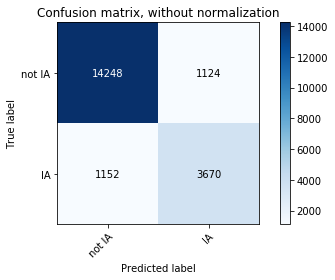

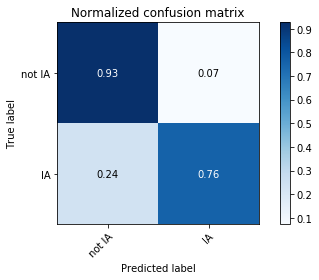

In [119]:
plot_confusion_matrix(y_train[0],y_pred, ['not IA','IA' ], normalize=False)
plot_confusion_matrix(y_train[0],y_pred, ['not IA','IA' ], normalize=True)